In [1]:
import numpy as np
from scipy import fftpack
import matplotlib.pyplot as plt

large = 40; med = 20; small = 20
params = {'axes.titlesize': med,'axes.titlepad' : med,
          'legend.fontsize': med,'axes.labelsize': med ,
          'axes.titlesize': med ,'xtick.labelsize': med ,
          'ytick.labelsize': med ,'figure.titlesize': med}
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams["font.serif"] = ["Helvetica Neue"]          
plt.rcParams.update(params)

In [2]:
import numpy as np
from scipy import fftpack

class GrossPitaevskiiSolver:
    def __init__(self, time_step, tmax, position_arr, potential_func, number_of_atoms, initial_wavefunction):
        self.h_bar = 1.0545718 * 10 ** (-34)
        self.trap_frequency = 2 * np.pi * 70  # Hz
        self.number_of_atoms = number_of_atoms
        self.atom_mass = 1.4192261 * 10 ** (-25)  # kg
        self.a_s = 98.006 * 5.29 * 10 ** (-11)  # m
        self.a_0 = np.sqrt(self.h_bar / (self.trap_frequency * self.atom_mass))
        self.g = 4 * np.pi * self.h_bar ** 2 * self.a_s / (np.pi * self.a_0 ** 2 * self.atom_mass)
        
        if 4 * np.pi * self.a_s * self.number_of_atoms < self.a_0:
            raise ValueError(f"4*np.pi*a_s*number_of_atoms ({4 * np.pi * self.a_s * self.number_of_atoms}) must be greater than a_0 ({self.a_0}).")

        number_density = self.number_of_atoms / (np.pi * self.a_0 ** 2 * (np.ptp(position_arr)))
        if number_density * self.a_s ** 3 > 1:
            raise ValueError(f"Gross-Pitaevskii equation is valid if: {number_density * self.a_s ** 3} << 1")

        self.time_step = time_step
        self.tmax = tmax
        self.position_arr = position_arr
        self.potential_func = potential_func

        self.N = len(self.position_arr)
        self.dx = np.ptp(self.position_arr) / self.N

        self.x_s = (4 * np.pi * self.a_s * self.number_of_atoms * self.a_0 ** 4) ** (1 / 5)
        self.epsilon = (self.a_0 / self.x_s) ** 2
        self.delta = (self.g * self.number_of_atoms * (self.x_s ** 2)) / (self.a_0 ** 3 * self.h_bar * self.trap_frequency)

        self.position_arr_dimless = self.position_arr / self.x_s
        self.dx_dimless = self.dx / self.x_s
        self.L_dimless = np.ptp(self.position_arr_dimless)
        self.dk_dimless = (2 * np.pi) / self.L_dimless
        self.time_step_dimless = self.time_step * self.trap_frequency
        self.tmax_dimless = self.tmax * self.trap_frequency

        def normalize(psi_x_dimless):
            return psi_x_dimless / np.sqrt(np.sum(np.abs(psi_x_dimless) ** 2) * self.dx_dimless)
            
        if initial_wavefunction is None:
            print("Initial wavefunction is not provided. Using a Gaussian wavefunction as the initial wavefunction.")
            amplitude = 1.0
            mean = np.mean(self.position_arr_dimless)
            std_dev = 0.1
            psi_initial_dimless = amplitude * np.exp(-(self.position_arr_dimless - mean) ** 2 / (2 * std_dev ** 2)) * np.sqrt(self.x_s)
            self.psi_x_dimless = normalize(psi_initial_dimless)
        else:
            # The wavefunction must have dimensions of [1/length]^(1/2).
            initial_wavefunction_dimless = initial_wavefunction * np.sqrt(self.x_s)
            self.psi_x_dimless = normalize(initial_wavefunction_dimless)
            print("Normalization of the initial wavefunction = ", np.sum(np.abs(self.psi_x_dimless) ** 2) * self.dx_dimless)

    def hamiltonian_x_dimless(self, potential_func, psi_x_dimless):
        return potential_func / (self.epsilon * self.atom_mass * self.trap_frequency ** 2 * self.x_s ** 2) + self.delta * self.epsilon ** (3 / 2) * np.abs(psi_x_dimless) ** 2

    def kinetic_energy_dimless(self):
        k_dimless = np.hstack([np.arange(0, self.N / 2), np.arange(-self.N / 2, 0)]) * self.dk_dimless
        if len(k_dimless) != self.N:
            k_dimless = np.hstack([np.arange(0, self.N / 2), np.arange(-self.N / 2 + 1, 0)]) * self.dk_dimless
        return k_dimless ** 2 * self.epsilon / 2

    def solve(self):

        total_iterations = int(np.abs(self.tmax_dimless) / np.abs(self.time_step_dimless))
        print('Total iterations: ', total_iterations)

        def normalize(psi_x_dimless):
            return psi_x_dimless / np.sqrt(np.sum(np.abs(psi_x_dimless) ** 2) * self.dx_dimless)
            
        for _ in range(total_iterations):
            self.psi_x_dimless = np.exp(-self.hamiltonian_x_dimless(self.potential_func, self.psi_x_dimless) * 1j * self.time_step_dimless / 2) * self.psi_x_dimless
            self.psi_x_dimless = normalize(self.psi_x_dimless)
            psi_k_dimless = fftpack.fft(self.psi_x_dimless)
            psi_k_dimless = np.exp(-(self.kinetic_energy_dimless() * 1j * self.time_step_dimless)) * psi_k_dimless

            self.psi_x_dimless = fftpack.ifft(psi_k_dimless)
            self.psi_x_dimless = normalize(self.psi_x_dimless)
            self.psi_x_dimless = np.exp(-self.hamiltonian_x_dimless(self.potential_func, self.psi_x_dimless) * 1j * self.time_step_dimless / 2) * self.psi_x_dimless
            self.psi_x_dimless = normalize(self.psi_x_dimless)

        print("Normalization of the final wavefunction: ", np.sum(np.abs(self.psi_x_dimless) ** 2) * self.dx_dimless)
        print("Number of atoms in the trap = ", (self.number_of_atoms)*np.sum(np.abs(self.psi_x_dimless) ** 2) * self.dx_dimless)
        return normalize(self.psi_x_dimless)

            
    def number_of_atoms_interval(self, psi_time_evolved, a, b):

        def normalize(psi_x_dimless):
                return psi_x_dimless / np.sqrt(np.sum(np.abs(psi_x_dimless) ** 2) * self.dx_dimless)
                
        psi_time_evolved = normalize(psi_time_evolved)
        a_dimless = a / self.x_s
        b_dimless = b / self.x_s
        psi_from_a_to_b_dimless = psi_time_evolved[np.logical_and(self.position_arr_dimless >= a_dimless, self.position_arr_dimless <= b_dimless)]
        return (self.number_of_atoms)*np.sum(np.abs(psi_from_a_to_b_dimless)**2)*self.dx_dimless

# Potential well

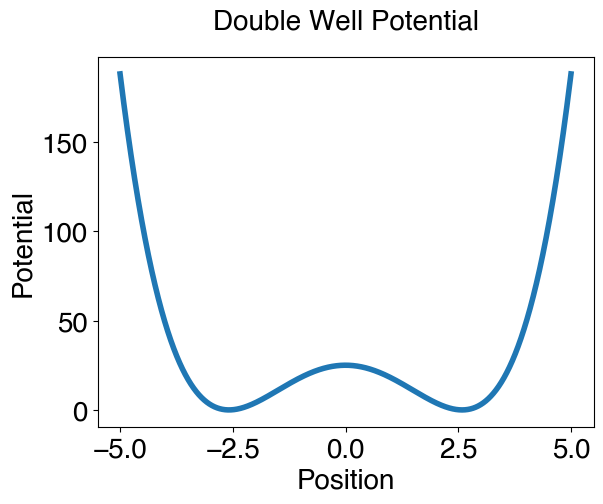

In [3]:
def double_well_potential(x, a, barrier_height):
    """
    Constructs a double well potential.
    
    Parameters:
    x (ndarray): Array of positions where the potential is evaluated.
    a (float): Parameter controlling the depth of the wells.
    b (float): Parameter controlling the separation and height of the barrier.
    
    Returns:
    V (ndarray): Array of potential values corresponding to positions x.
    """
    b = (barrier_height/a)**(1/4)

    V = a * (x**2 - b**2)**2
    return V # in kHz.

# Example usage
double_well_position = np.linspace(-5.0, 5.0, 2**14) # in micrometers.
double_well_potential = double_well_potential(double_well_position, 5.6*1.e-1, 25)

# Plotting the potential
plt.plot(double_well_position, double_well_potential, linewidth=4)
plt.xlabel('Position')
plt.ylabel('Potential')
plt.title('Double Well Potential')
#plt.grid(True)
plt.show()

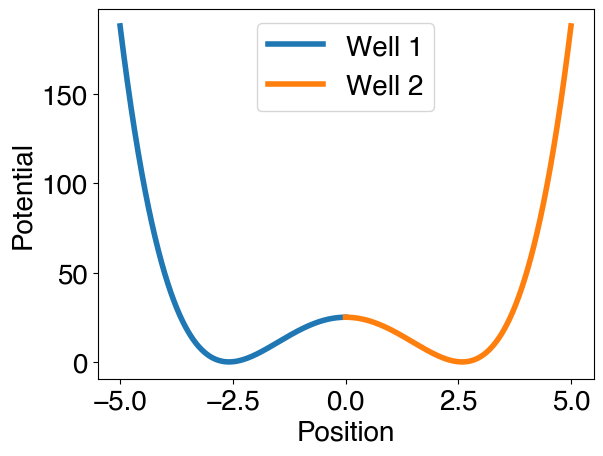

In [4]:
# Here will separate the potential into two wells.
left_well_position = double_well_position[double_well_position <= 0]
left_well_potential = double_well_potential[double_well_position <= 0]
right_well_position = double_well_position[double_well_position >= 0]
right_well_potential = double_well_potential[double_well_position >= 0]
plt.plot(left_well_position, left_well_potential , linewidth=4, label="Well 1")
plt.plot(right_well_position, right_well_potential, linewidth=4, label="Well 2")
plt.legend()
plt.xlabel('Position')
plt.ylabel('Potential')
plt.show()

# Left well

In [5]:
# Parameters
time_step = -1j*10**(-6) # In seconds unit.
tmax = 1.e-2 # In seconds unit.
N_atom_left = 5000 # Total number of atoms

h_bar = 1.0545718 * 10**(-34)
solver_left = GrossPitaevskiiSolver(time_step, tmax, left_well_position*1.e-6, left_well_potential*10**3*h_bar*2*np.pi, N_atom_left, None)
print(solver_left.dx_dimless*solver_left.x_s)
left_well_ground_state_dimless = solver_left.solve()

Initial wavefunction is not provided. Using a Gaussian wavefunction as the initial wavefunction.
6.103143073231398e-10
Total iterations:  10000
Normalization of the final wavefunction:  0.9999999999999998
Number of atoms in the trap =  4999.999999999999


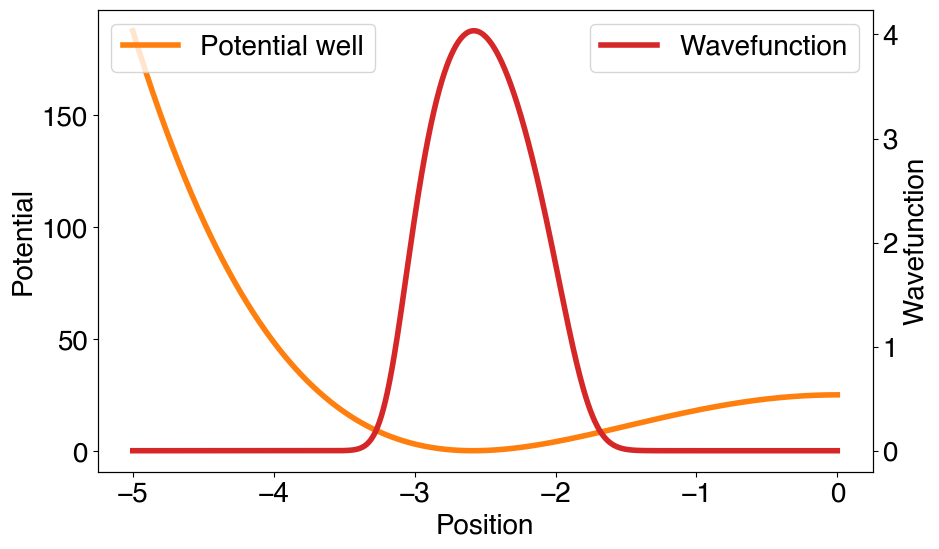

In [6]:
# Plotting the two potential wells and two wavefunctions together in the same plot.
fig, ax1 = plt.subplots()
fig.set_size_inches(10, 6)
ax2 = ax1.twinx()
ax1.plot(left_well_position, left_well_potential, "tab:orange", linewidth=4, label="Potential well")
ax2.plot(left_well_position, np.abs(left_well_ground_state_dimless)**2, "tab:red", linewidth=4, label="Wavefunction")
ax1.set_xlabel('Position')
ax1.set_ylabel('Potential')

ax2.set_ylabel('Wavefunction')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

# Right well

In [7]:
# Parameters
time_step = -1j*10**(-6) # In seconds unit.
tmax = 1.e-2 # In seconds unit.
N_atom_right = 40000 # Total number of atoms
 
h_bar = 1.0545718 * 10**(-34)
solver_right = GrossPitaevskiiSolver(time_step, tmax, right_well_position*1.e-6, right_well_potential*10**3*h_bar*2*np.pi, N_atom_right, None)
print(solver_right.dx_dimless*solver_right.x_s)
right_well_ground_state_dimless = solver_right.solve()

Initial wavefunction is not provided. Using a Gaussian wavefunction as the initial wavefunction.
6.103143073231398e-10
Total iterations:  10000
Normalization of the final wavefunction:  0.9999999999999999
Number of atoms in the trap =  39999.99999999999


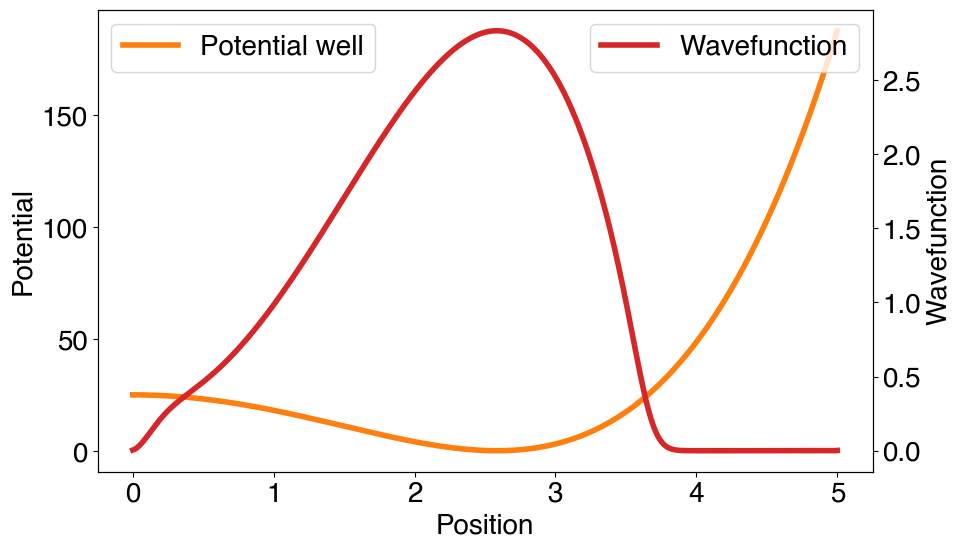

In [8]:
# Plotting the two potential wells and two wavefunctions together in the same plot.
fig, ax1 = plt.subplots()
fig.set_size_inches(10, 6)
ax2 = ax1.twinx()
ax1.plot(right_well_position, right_well_potential, "tab:orange", linewidth=4, label="Potential well")
ax2.plot(right_well_position, np.abs(right_well_ground_state_dimless)**2, "tab:red", linewidth=4, label="Wavefunction")
ax1.set_xlabel('Position')
ax1.set_ylabel('Potential')

ax2.set_ylabel('Wavefunction')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

# Double well

In [12]:
# Concate the two wavefunctions.
print("Normalization of the left well wavefunction: ", np.sum(np.abs(left_well_ground_state_dimless)**2)*solver_left.dx_dimless)
print("Normalization of the right well wavefunction: ", np.sum(np.abs(right_well_ground_state_dimless)**2)*solver_right.dx_dimless)
left_well_ground_state = left_well_ground_state_dimless/np.sqrt(solver_left.x_s)
right_well_ground_state = right_well_ground_state_dimless/np.sqrt(solver_right.x_s)
psi_two_wells_initial = np.hstack([np.sqrt(N_atom_left/(N_atom_left+N_atom_right))*left_well_ground_state, np.sqrt(N_atom_right/(N_atom_left+N_atom_right))*right_well_ground_state])

# Construct the double well potential.
two_wells_position = np.hstack([left_well_position, right_well_position])
two_wells_potential = np.hstack([left_well_potential, right_well_potential])

# Real time evolution of the wavefunction.
# Parameters
dt = 10**(-8) # In seconds unit.
tmax = 10*1.e-3 # In seconds unit.
N_atom = N_atom_left + N_atom_right # Total number of atoms

solver_total = GrossPitaevskiiSolver(dt, tmax, two_wells_position*1.e-6, two_wells_potential*10**3*h_bar*2*np.pi, N_atom, psi_two_wells_initial)
psi_two_wells_final_dimless = solver_total.solve()

Normalization of the left well wavefunction:  1.0000000000000002
Normalization of the right well wavefunction:  1.0000000000000004
Normalization of the initial wavefunction =  1.0000000000000002
Total iterations:  1000000


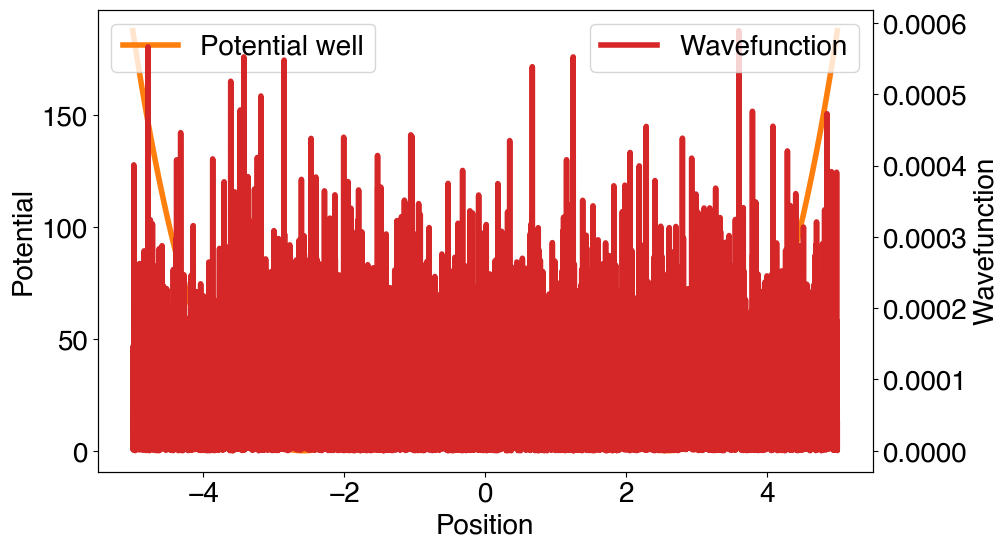

In [ ]:
# Plotting the two potential wells and two wavefunctions together in the same plot.
fig, ax1 = plt.subplots()
fig.set_size_inches(10, 6)
ax2 = ax1.twinx()
ax1.plot(two_wells_position, two_wells_potential, "tab:orange", linewidth=4, label="Potential well")
ax2.plot(two_wells_position, np.abs(psi_two_wells_final_dimless/np.sqrt(solver_total.x_s))**2*solver_total.dx_dimless*solver_total.x_s, "tab:red", linewidth=4, label="Wavefunction")
ax1.set_xlabel('Position')
ax1.set_ylabel('Potential')

ax2.set_ylabel('Wavefunction')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

In [ ]:
solver_total.number_of_atoms_interval(psi_two_wells_initial, -5.e-6, 0.e-6)

In [ ]:
solver_total.number_of_atoms_interval(psi_two_wells_initial, 0.e-6, 5.e-6)

In [ ]:
solver_total.number_of_atoms_interval(psi_two_wells_initial, -5.e-6, 5.e-6)